This is the third part of the first lab.

The setup remains the same as in the previous parts, and the following is included only in case this part is not conducted immendately after the second part.  


###### Setup:  
-- Insert transceiver in intl0 (B).    
-- `rmmod ixgbe && modprobe ixgbe allow_unsupported_sfp=1` (Machine B)   
-- `ifconfig intl0 192.168.0.2` (Machine B)  
-- `ifconfig slf0 192.168.0.1` (Machine A)  
-- `ssh-add` (Machine A) #if it fails, run first: eval `ssh-agent -s`  
-- `mkdir /root/<crsid>` (Machine A, replace <crsid> with your crsid) 
  
-- `cd /root/<crsid>` Machine A)  
-- `git clone http://github.com/cucl-srg/L50` (Machine A)  
-- `/root/L50/setup/mkdir1.sh <crsid>`. (Machine A)   
-- Connect slf0 (A) to intl0 (B)  
<img src="alt_setup1.jpg">  

In [54]:
crsid='jlf60' #your crsid
%run /root/$crsid/L50/Jupyter/useful/useful.py
%run /root/$crsid/L50/Jupyter/useful/useful1.py
%matplotlib inline
machB_ip = '128.232.82.64'
machA_ip = '128.232.82.63'
machB_ip_local = '192.168.0.2'
machA_ip_local = '192.168.0.1'

# 3. iperf

iperf is used to test the maximum network throughput that a computer can handle. The DuT acts as an iperf server and listens for connections. A second computer connects to the server and sends datagrams.  
  
In bidirectional testing, both computers act as both servers (receiving) and clients (sending).  
  
###### Usage of iperf: 
    
Server:  
* TCP       
`iperf -s -B <server address>`  
* UDP      
`iperf -s -B <server address>` -u   
   
Client:  
* TCP     
`iperf -c <server address> [Opt: -i <interval>] [Opt: -t <time>] [Opt: -f <format>] [Opt: -d] [Opt: -w <TCP window size>]`  
interval = how often to report bandwidth in seconds. Default is no periodic reports.  
time = length of test in seconds. Default value is 10.    
format = 'k' for Kbits/sec, 'm' for Mbits/sec, 'g' for Gbits/sec. Default is adaptive.    
-d = bidirectional  
TCP window size -> eg. `-w 20KB`
    
      
* UDP    
`iperf -c <server address> [Opt: -i <interval>] [Opt: -t <time>] [Opt: -f <format>] [Opt: -d] [Opt: -b <bandwidth>]`   
bandwidth -> eg. `-b 20m` (Mbits/sec).  

NB. By default, iperf restricts bandwidth for UDP clients to a maximum of 1 Mbit/sec. There is no restriction for TCP clients.   

### Experiment 9

Run one way iperf, from A to B, 10 sec long. Plot the bandwidth for each time interval (1 sec).

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, 10 seconds long, interval 1 second, format Gbits/sec.

In [80]:
server_cmd = 'iperf -s -B '+machB_ip_local
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

for i in range(5):
    sleep(1)
    client_cmd ='iperf -c '+machB_ip_local+' -i 1 -t 10 -f g'
    local_cmd(client_cmd+'| grep -e "bits/sec" -m 10 > /root/'+crsid+'/L50Lab1/9/exp9_' + str(i))

ssh_cmd('pkill iperf', ssh)
ssh.close()

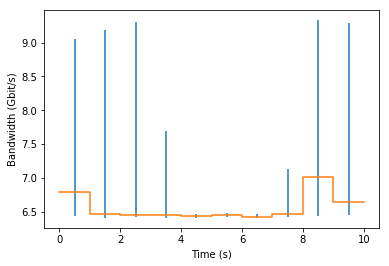

In [81]:
bws = data_iperf('9/exp9',crsid)
ys, yerr = graph_error(bws)
plt.errorbar(np.arange(0.5,10.0,1.0),ys,yerr=yerr,linestyle="none")
ys.append(ys[-1])
plt.step(np.arange(0,11,1), ys ,where="post")

plt.xlabel("Time (s)")
plt.ylabel("Bandwidth (Gbit/s)")
plt.show()

### Experiment 10

Run 2 way iperf, 10 sec long. Plot the bandwidth for each time interval (1 sec).

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, bidirectional, 10 seconds long, interval 1 second, format Gbits/sec.

In [78]:
server_cmd = 'iperf -s -B '+machB_ip_local
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

for i in range(5):
    sleep(1)
    client_cmd = 'iperf -c '+machB_ip_local+' -i 1 -t 10 -f g -d'
    local_cmd(client_cmd+' | grep -e "bits/sec" -e "with" -m 22 > /root/'+crsid+'/L50Lab1/10/exp10_' + str(i))
    #print(local_cmd(client_cmd))

ssh_cmd('pkill iperf', ssh)
ssh.close()

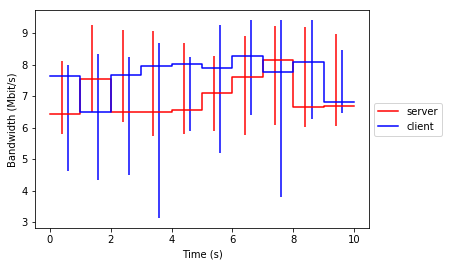

In [79]:
sbw,cbw = data10(crsid)
ys,yerr = graph_error(sbw)
plt.errorbar(np.arange(0.4,10.0,1.0),ys,yerr=yerr,linestyle="none",color="red")
ys.append(ys[-1])
plt.step(np.arange(0,11,1), ys ,where="post",color="red",label="server")

ys2,yerr2 = graph_error(cbw)
plt.errorbar(np.arange(0.6,10.0,1.0),ys2,yerr=yerr2,linestyle="none",color="blue")
ys2.append(ys2[-1])
plt.step(np.arange(0,11,1), ys2 ,where="post",color="blue",label="client")
    
plt.xlabel("Time (s)")
plt.ylabel("Bandwidth (Mbit/s)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Experiment 11

Run one way iperf, from A to B, 3 sec long, with varying window size. Plot the bandwidth for each window size.

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, 3 seconds long, format Kbits/sec, for each window size in KB.

In [76]:
server_cmd = 'iperf -s -B '+machB_ip_local
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

windows = [1,50,100,150,200,250]
for w in windows:
    for i in range(5):
        sleep(1)
        client_cmd = 'iperf -c '+machB_ip_local+' -t 3 -f k -w '+str(w)+'KB'
        local_cmd(client_cmd+' | grep -e "window" -e "bits/sec" > /root/'+crsid+'/L50Lab1/11/exp11_'+str(w)+'_'+str(i))
        #print(local_cmd(client_cmd))
        
ssh_cmd('pkill iperf', ssh)
ssh.close()

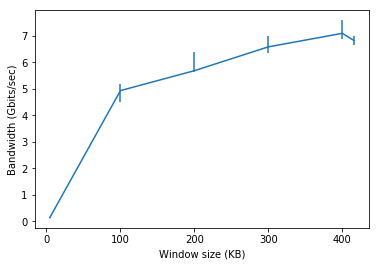

In [77]:
winds, bws = data11(windows,crsid)
ys,yerr =graph_error(bws)
plt.errorbar(winds,ys,yerr=yerr)
plt.ylabel("Bandwidth (Gbits/sec)")
plt.xlabel("Window size (KB)")
plt.show()

### Experiment 12

Run one way iperf using UDP, from A to B, 3 sec long, with varying bandwidth. Plot the percentage of packets dropped for each bandwidth.

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the UDP server. Fill in `client_cmd`, the command to connect to the UDP server, 3 seconds long, format Mbits/sec, for each bandwidth in Mbits/sec.

In [56]:
server_cmd = 'iperf -s -B '+machB_ip_local+' -u'
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

bands = [10,100,1000,5000,9000]
for b in bands:
    for i in range(5):
        sleep(1)
        client_cmd = 'iperf -c '+machB_ip_local+' -i 1 -t 3 -f m -b '+str(b)+'m'
        local_cmd(client_cmd+' | grep -e "%"> /root/'+crsid+'/L50Lab1/12/exp12_'+str(b)+ '_'+ str(i))
        print(local_cmd(client_cmd))
    
ssh_cmd('pkill iperf', ssh)
ssh.close()

------------------------------------------------------------
Client connecting to 192.168.0.2, UDP port 5001
Sending 1470 byte datagrams
UDP buffer size: 0.20 MByte (default)
------------------------------------------------------------
[  3] local 192.168.0.1 port 52187 connected with 192.168.0.2 port 5001
[ ID] Interval       Transfer     Bandwidth
[  3]  0.0- 1.0 sec  1.19 MBytes  10.0 Mbits/sec
[  3]  1.0- 2.0 sec  1.19 MBytes  10.0 Mbits/sec
[  3]  2.0- 3.0 sec  1.19 MBytes  10.0 Mbits/sec
[  3]  0.0- 3.0 sec  3.58 MBytes  10.0 Mbits/sec
[  3] Sent 2552 datagrams
[  3] Server Report:
[  3]  0.0- 6.0 sec  3.58 MBytes  4.97 Mbits/sec   0.006 ms    0/ 2552 (0%)

------------------------------------------------------------
Client connecting to 192.168.0.2, UDP port 5001
Sending 1470 byte datagrams
UDP buffer size: 0.20 MByte (default)
------------------------------------------------------------
[  3] local 192.168.0.1 port 33043 connected with 192.168.0.2 port 5001
[ ID] Interval      

------------------------------------------------------------
Client connecting to 192.168.0.2, UDP port 5001
Sending 1470 byte datagrams
UDP buffer size: 0.20 MByte (default)
------------------------------------------------------------
[  3] local 192.168.0.1 port 42064 connected with 192.168.0.2 port 5001
[ ID] Interval       Transfer     Bandwidth
[  3]  0.0- 1.0 sec  97.3 MBytes   816 Mbits/sec
[  3]  1.0- 2.0 sec  96.6 MBytes   810 Mbits/sec
[  3]  2.0- 3.0 sec  96.9 MBytes   813 Mbits/sec
[  3]  0.0- 3.0 sec   291 MBytes   813 Mbits/sec
[  3] Sent 207415 datagrams
[  3] Server Report:
[  3]  0.0- 6.0 sec   271 MBytes   377 Mbits/sec   0.001 ms 13830/207414 (6.7%)
[  3]  0.0- 6.0 sec  1 datagrams received out-of-order

------------------------------------------------------------
Client connecting to 192.168.0.2, UDP port 5001
Sending 1470 byte datagrams
UDP buffer size: 0.20 MByte (default)
------------------------------------------------------------
[  3] local 192.168.0.1 port 42

------------------------------------------------------------
Client connecting to 192.168.0.2, UDP port 5001
Sending 1470 byte datagrams
UDP buffer size: 0.20 MByte (default)
------------------------------------------------------------
[  3] local 192.168.0.1 port 35816 connected with 192.168.0.2 port 5001
[ ID] Interval       Transfer     Bandwidth
[  3]  0.0- 1.0 sec  95.9 MBytes   804 Mbits/sec
[  3]  1.0- 2.0 sec  95.9 MBytes   804 Mbits/sec
[  3]  0.0- 3.0 sec   288 MBytes   804 Mbits/sec
[  3] Sent 205121 datagrams
[  3] Server Report:
[  3]  0.0- 6.3 sec  80.3 MBytes   107 Mbits/sec  15.659 ms 147827/205120 (72%)
[  3]  0.0- 6.3 sec  1 datagrams received out-of-order



<font color='red'>TODO:</font> Plot a graph of percentage of packets dropped against bandwidth, with error bars.

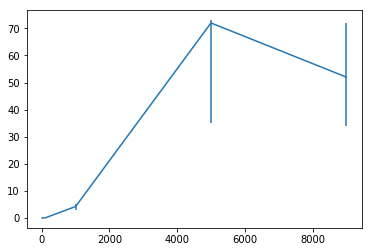

In [75]:
bans,pcs = data_band('12/exp12',crsid,bands)
ys, yerr = graph_error(pcs)

plt.errorbar(bands,ys,yerr=yerr)
plt.show()

### Experiment 13

###### Usage of iperf3 :   
  
Server:  
* TCP/UDP      
`iperf3 -s -B <server address>`     
     
Client:  
* TCP     
`iperf3 -c <server address> [Opt: -i <interval>] [Opt: -t <time>] [Opt: -f <format>] [Opt: -w <window size>]`     
* UDP     
`iperf3 -c <server address> [Opt: -i <interval>] [Opt: -t <time>] [Opt: -f <format>] [Opt: -b <bandwidth>]`

### 13a

Run one way iperf, from A to B, 10 sec long. Plot the bandwidth for each time interval (1 sec).

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, 10 seconds long, format Gbits/sec, interval 1 second.

In [84]:
server_cmd = 'iperf3 -s -B '+machB_ip_local
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

for i in range(5):
    sleep(1)
    client_cmd = 'iperf3 -c '+machB_ip_local+' -t 10 -f g -i 1'
    local_cmd(client_cmd+' | grep -e "bits/sec" -m 10 > /root/'+crsid+'/L50Lab1/13/exp13a_' + str(i))

ssh_cmd('pkill iperf3', ssh)
ssh.close()

<font color='red'>TODO:</font> Plot a step graph of bandwidth against time, with error bars.

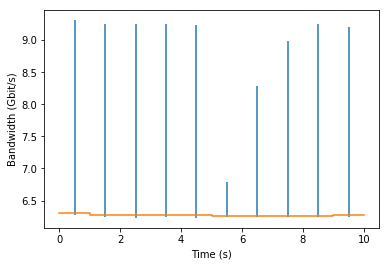

In [87]:
bws = data_iperf('13/exp13a',crsid)
ys, yerr = graph_error(bws)

plt.errorbar(np.arange(0.5,10.0,1.0),ys,yerr=yerr,linestyle="none")
ys.append(ys[-1])
plt.step(np.arange(0,11,1), ys ,where="post")

plt.xlabel("Time (s)")
plt.ylabel("Bandwidth (Gbit/s)")
plt.show()

### 13b

Run one way iperf, from A to B, 3 sec long, with varying window size. Plot the bandwidth for each window size.

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, 3 seconds long, format Mbits/sec, for every window size in KB.

In [106]:
server_cmd ='iperf3 -s -B '+machB_ip_local
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

windows = [1,50,100,150,200,250]
for w in windows:
    for i in range(5):
        sleep(1)
        client_cmd = 'iperf3 -c '+machB_ip_local+' -t 3 -f m -w '+str(w)+'KB'
        local_cmd(client_cmd +' | grep -e "bits/sec" > /root/'+crsid+'/L50Lab1/13/exp13b_'+str(w)+'_'+str(i))
    
ssh_cmd('pkill iperf3', ssh)
ssh.close()

<font color='red'>TODO:</font> Plot a graph of bandwidth against window size, with error bars.

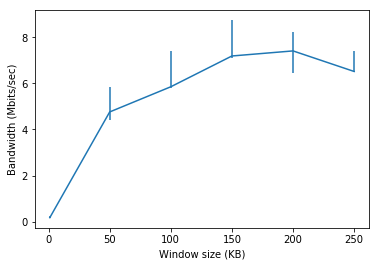

In [93]:
bws = data13b(windows,crsid)
ys,yerr = graph_error(bws)

plt.errorbar(windows,ys,yerr=yerr)
plt.ylabel("Bandwidth (Mbits/sec)")
plt.xlabel("Window size (KB)")
plt.show()

### 13c

Run one way iperf using UDP, from A to B, 3 sec long, with varying bandwidth. Plot the percentage of packets dropped for each bandwidth.

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the UDP server. Fill in `client_cmd`, the command to connect to the UDP server, 3 seconds long, format Mbits/sec, for every bandwidth in Mbits/sec.

In [111]:
server_cmd = 'iperf3 -s -B '+machB_ip_local
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

bands = [10,100,1000,5000,9000]
for b in bands:
    for i in range(5):
        sleep(1)
        client_cmd = 'iperf3 -u -c '+machB_ip_local+' -t 3 -f m -b '+str(b)+'m'
        local_cmd(client_cmd+' | grep "%" > /root/'+crsid+'/L50Lab1/13/exp13c_'+str(b)+'_'+str(i))
        print(local_cmd(client_cmd))
    
ssh_cmd('pkill iperf', ssh)
ssh.close()

Connecting to host 192.168.0.2, port 5201
[  4] local 192.168.0.1 port 45254 connected to 192.168.0.2 port 5201
[ ID] Interval           Transfer     Bandwidth       Total Datagrams
[  4]   0.00-1.00   sec  1.08 MBytes  9.04 Mbits/sec  138  
[  4]   1.00-2.00   sec  1.19 MBytes  9.96 Mbits/sec  152  
[  4]   2.00-3.00   sec  1.20 MBytes  10.0 Mbits/sec  153  
- - - - - - - - - - - - - - - - - - - - - - - - -
[ ID] Interval           Transfer     Bandwidth       Jitter    Lost/Total Datagrams
[  4]   0.00-3.00   sec  3.46 MBytes  9.68 Mbits/sec  0.015 ms  49/443 (11%)  
[  4] Sent 443 datagrams

iperf Done.

Connecting to host 192.168.0.2, port 5201
[  4] local 192.168.0.1 port 39253 connected to 192.168.0.2 port 5201
[ ID] Interval           Transfer     Bandwidth       Total Datagrams
[  4]   0.00-1.00   sec  1.08 MBytes  9.04 Mbits/sec  138  
[  4]   1.00-2.00   sec  1.19 MBytes  9.96 Mbits/sec  152  
[  4]   2.00-3.00   sec  1.20 MBytes  10.0 Mbits/sec  153  
- - - - - - - - - - - -

Connecting to host 192.168.0.2, port 5201
[  4] local 192.168.0.1 port 52054 connected to 192.168.0.2 port 5201
[ ID] Interval           Transfer     Bandwidth       Total Datagrams
[  4]   0.00-1.00   sec   111 MBytes   934 Mbits/sec  14252  
[  4]   1.00-2.00   sec   119 MBytes  1000 Mbits/sec  15262  
[  4]   2.00-3.00   sec   119 MBytes  1000 Mbits/sec  15259  
- - - - - - - - - - - - - - - - - - - - - - - - -
[ ID] Interval           Transfer     Bandwidth       Jitter    Lost/Total Datagrams
[  4]   0.00-3.00   sec   350 MBytes   978 Mbits/sec  0.010 ms  7/44773 (0.016%)  
[  4] Sent 44773 datagrams

iperf Done.

Connecting to host 192.168.0.2, port 5201
[  4] local 192.168.0.1 port 44030 connected to 192.168.0.2 port 5201
[ ID] Interval           Transfer     Bandwidth       Total Datagrams
[  4]   0.00-1.00   sec   381 MBytes  3200 Mbits/sec  48831  
[  4]   1.00-2.00   sec   623 MBytes  5224 Mbits/sec  79711  
[  4]   2.00-3.00   sec   682 MBytes  5720 Mbits/sec  87279  
- - -

<font color='red'>TODO:</font> Plot a graph of percentage of packets dropped against bandwidth, with error bars.

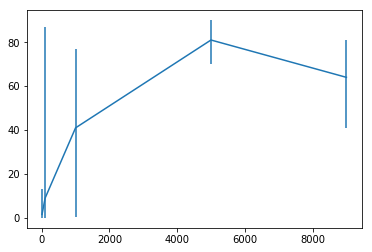

In [113]:
bans,pcs = data_band('13/exp13c',crsid,bands)
ys, yerr = graph_error(pcs)


plt.errorbar(bands,ys,yerr=yerr)
plt.show()